In [4]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9033 sha256=f8ce5e328f4f290f47578802202b165104ca4ccac5c19f09c77c7d1ea82f45e0
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown


In [1]:
BATCH_SIZE = 8

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import re
try:
    from kaggle_datasets import KaggleDatasets
except:
    pass

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [7]:
GCS_PATH = KaggleDatasets().get_gcs_path("gan-getting-started")

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)

fast_photo_ds = load_dataset(PHOTO_FILENAMES).batch(BATCH_SIZE*strategy.num_replicas_in_sync).prefetch(BATCH_SIZE)
fid_photo_ds = load_dataset(PHOTO_FILENAMES).take(BATCH_SIZE).batch(BATCH_SIZE*1).prefetch(BATCH_SIZE)

In [19]:
import gdown

url = 'https://drive.google.com/uc?id=1VU-Ud8kUHOAccP2majaqEfD9S8mMslbn'
output = 'model.h5'
gdown.download(url, output)


Downloading...
From: https://drive.google.com/uc?id=1VU-Ud8kUHOAccP2majaqEfD9S8mMslbn
To: /kaggle/working/model.h5
218MB [00:02, 91.8MB/s] 


'model.h5'

In [25]:
OUTPUT_CHANNELS = 3

def down_sample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False),# (size, 128, 128, 64)
        down_sample(128, 4),                         # (size, 64, 64, 128)
        down_sample(256, 4),                         # (size, 32, 32, 256)
        down_sample(512, 4),                         # (size, 16, 16, 512)
        down_sample(512, 4),                         # (size, 8, 8, 512)
        down_sample(512, 4),                         # (size, 4, 4, 512)
        down_sample(512, 4),                         # (size, 2, 2, 512)
        down_sample(512, 4),                         # (size, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),       # (size, 2, 2, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 4, 4, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 8, 8, 1024)
        up_sample(512, 4),                           # (size, 16, 16, 1024)
        up_sample(256, 4),                           # (size, 32, 32, 512)
        up_sample(128, 4),                           # (size, 64, 64, 256)
        up_sample(64, 4),                            # (size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 
    # (size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


monet_generator = Generator()
monet_generator.load_weights("model.h5")

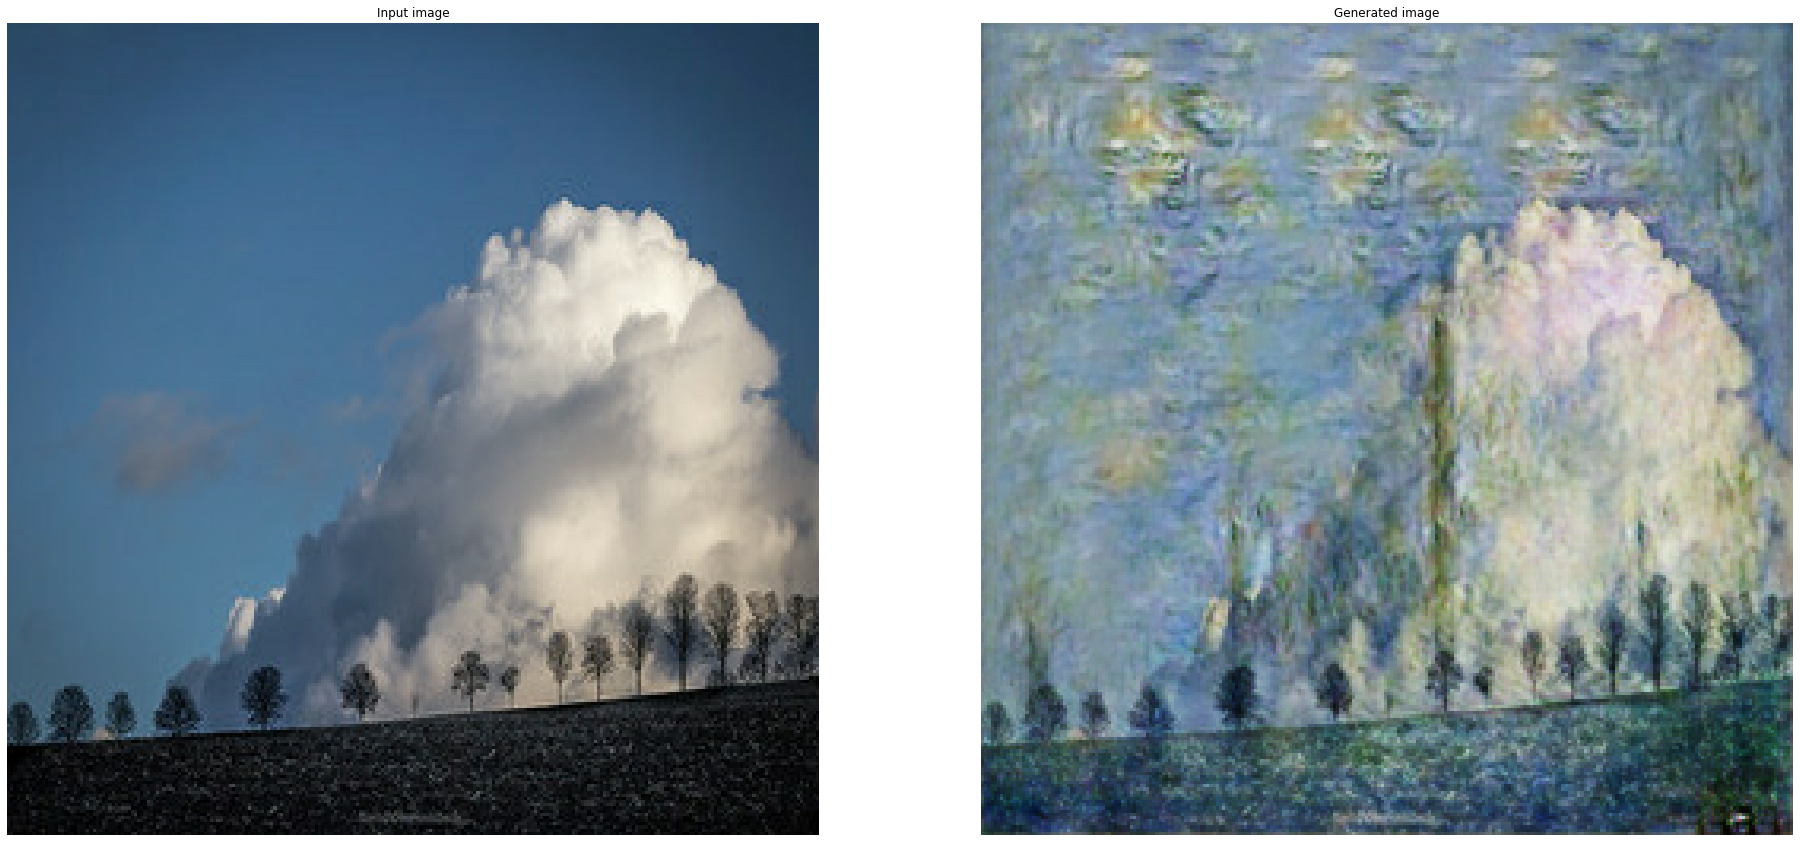

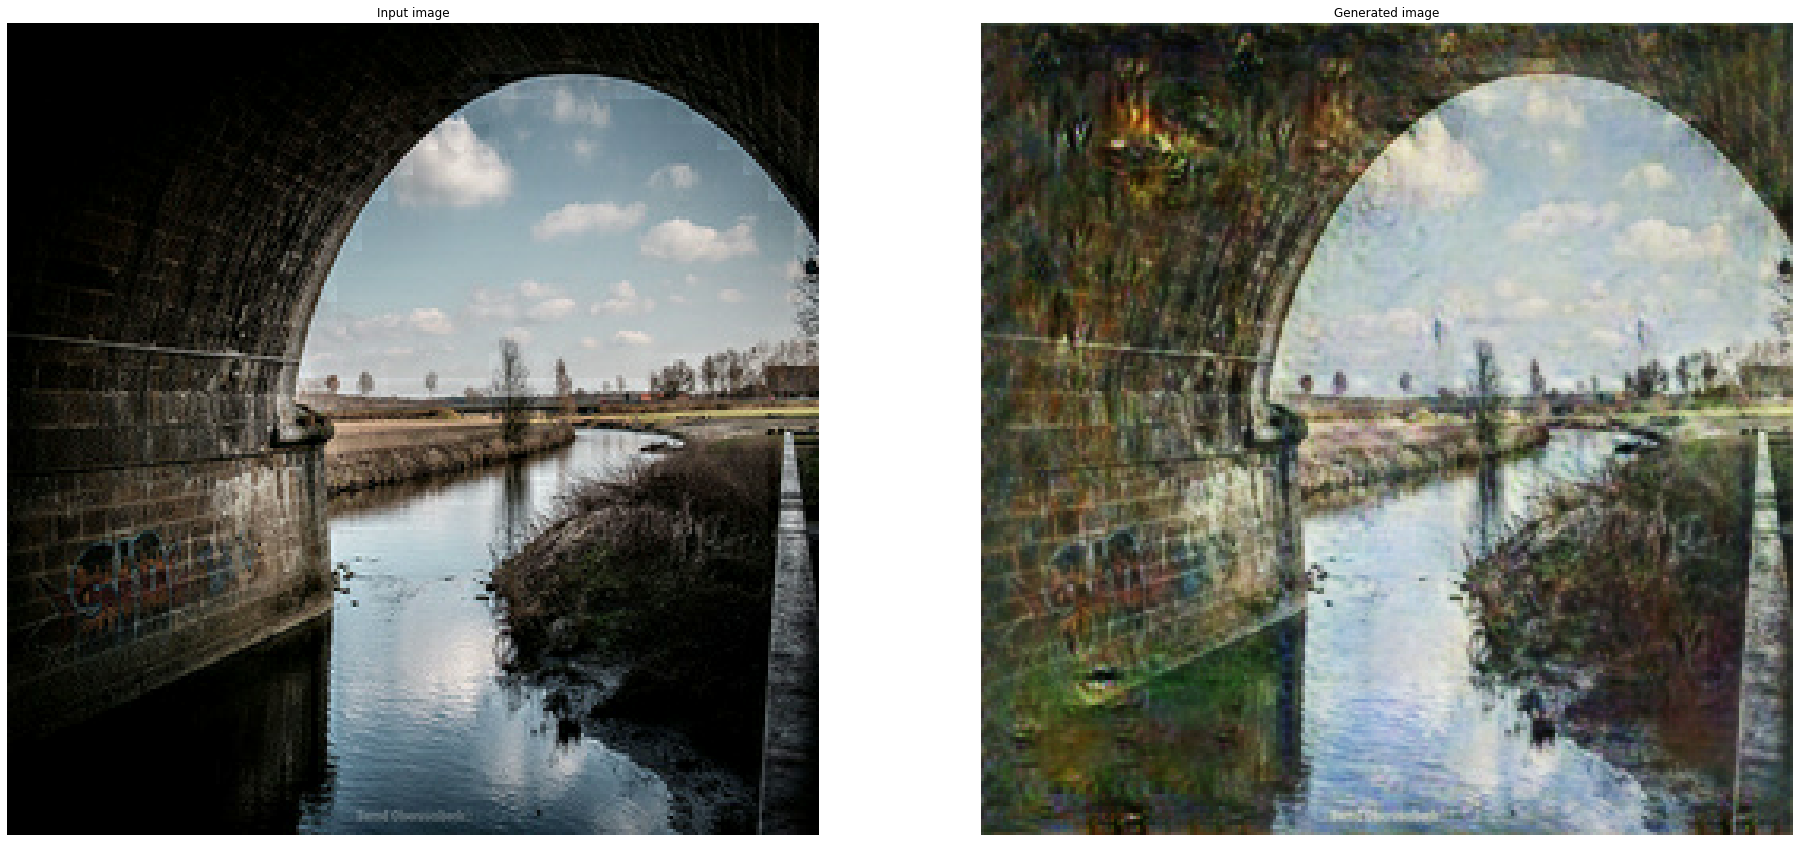

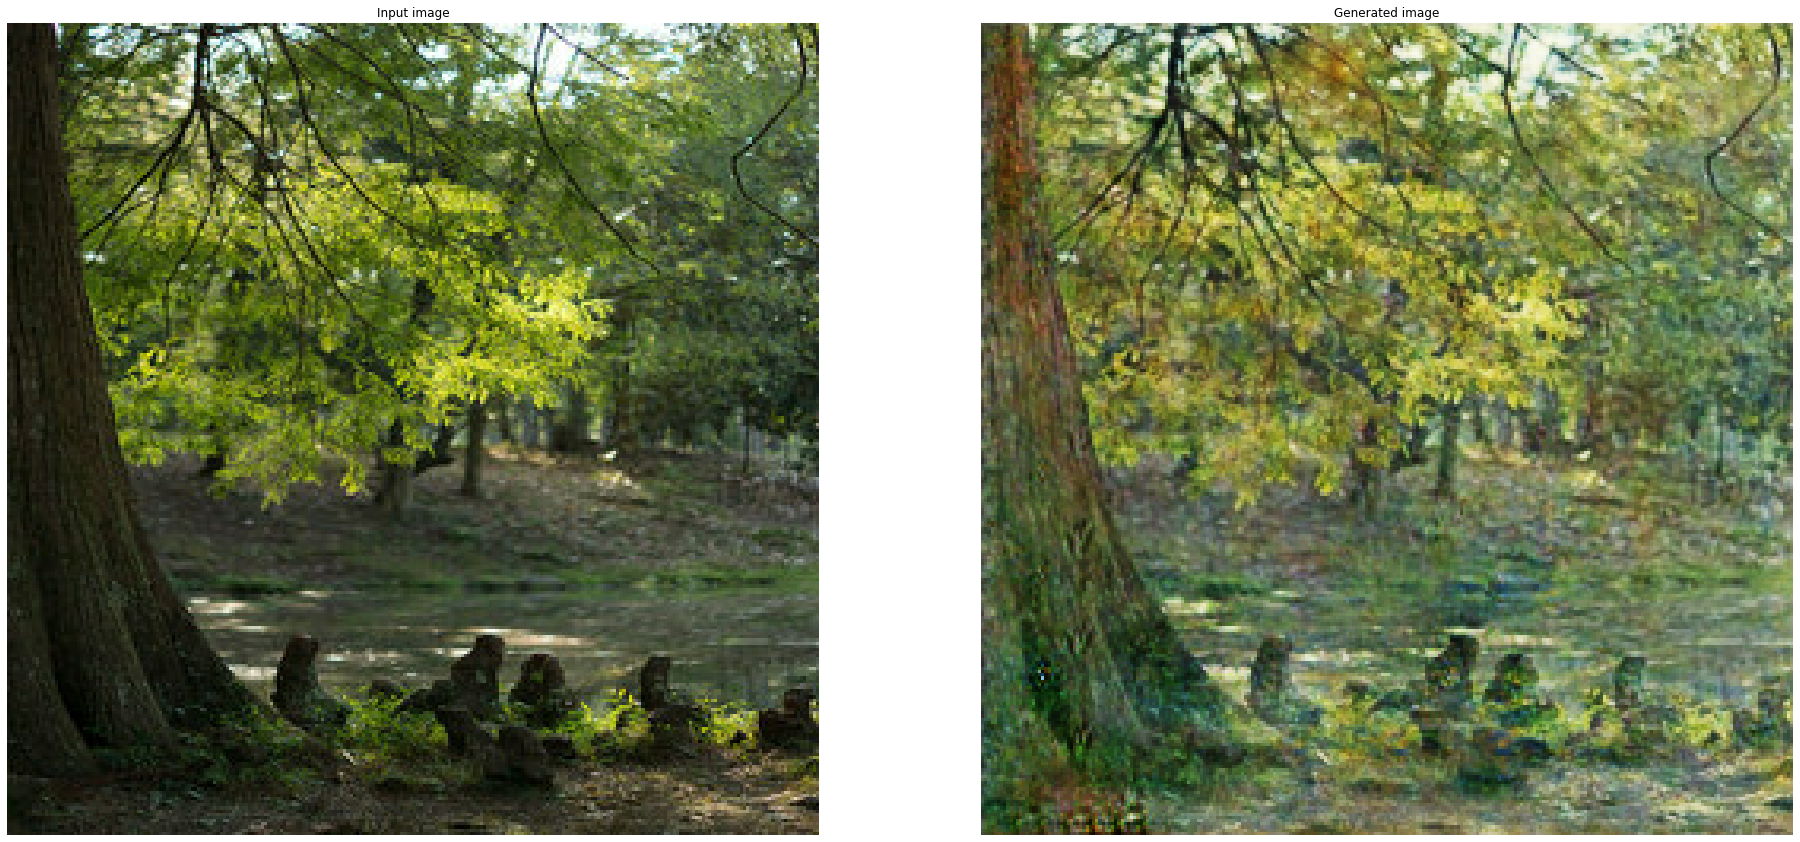

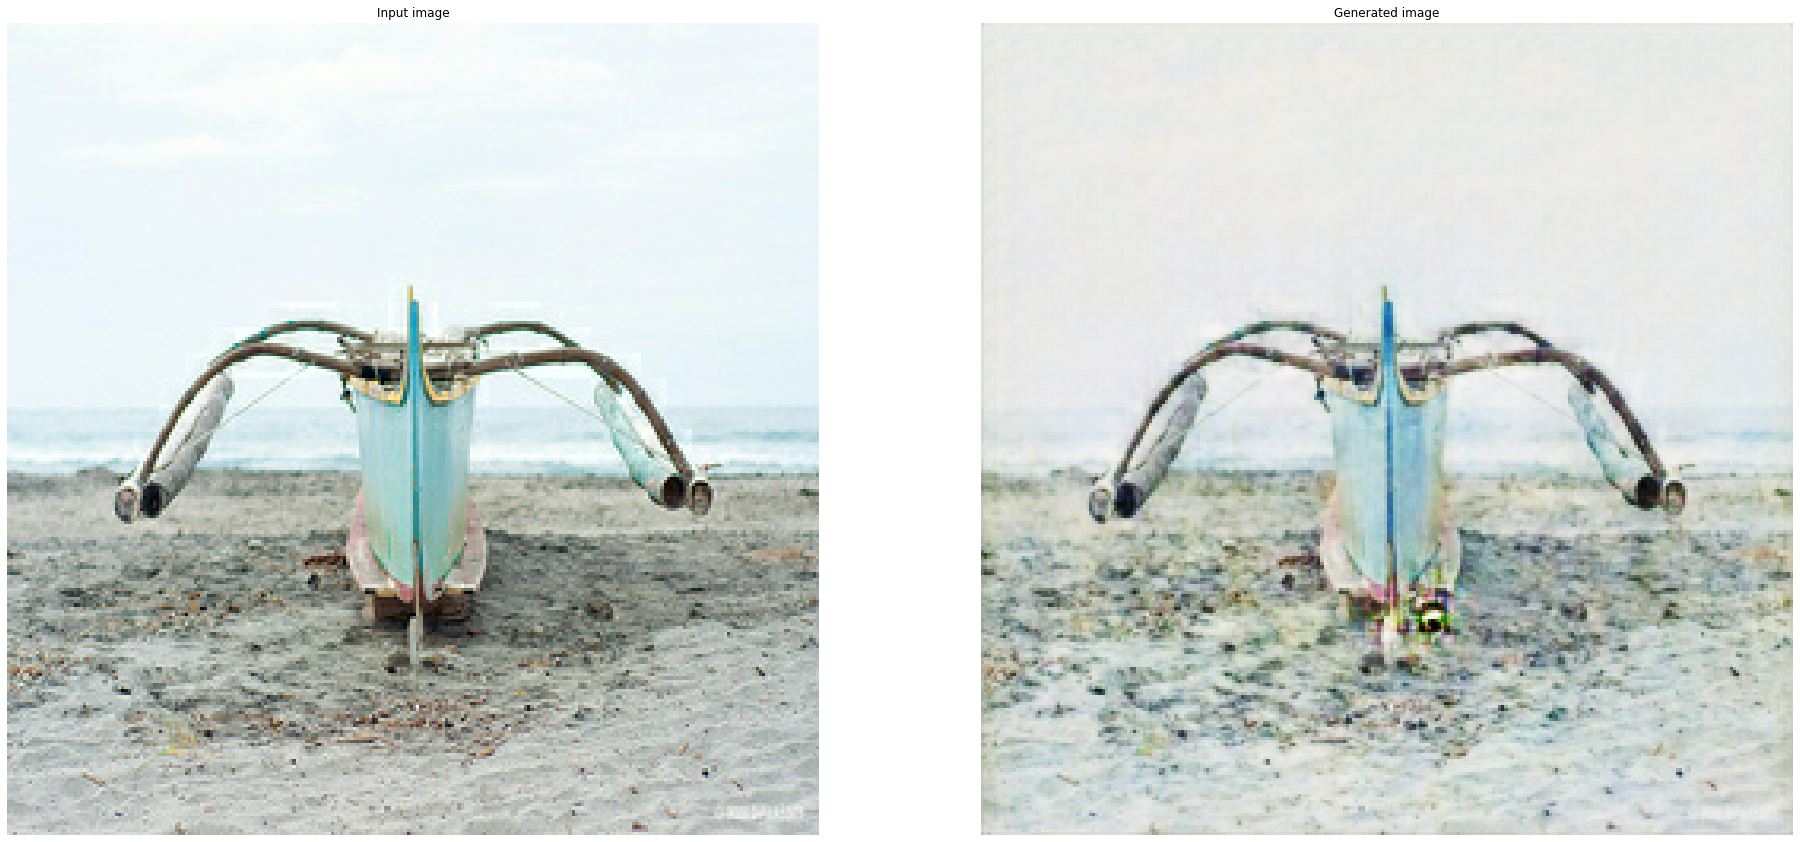

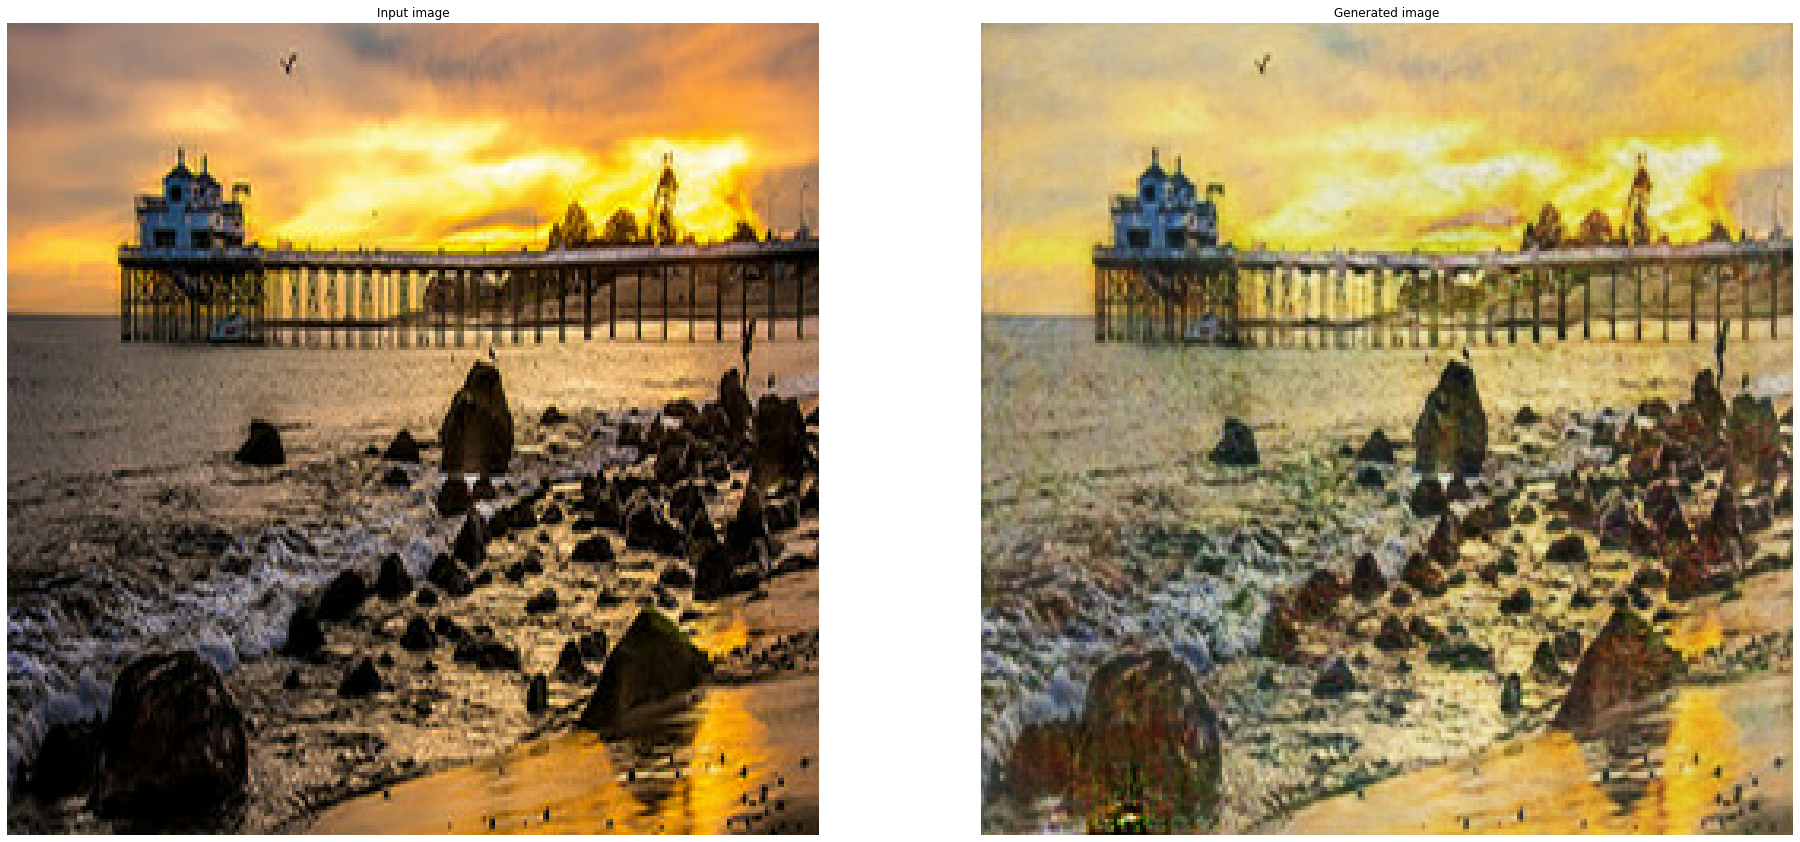

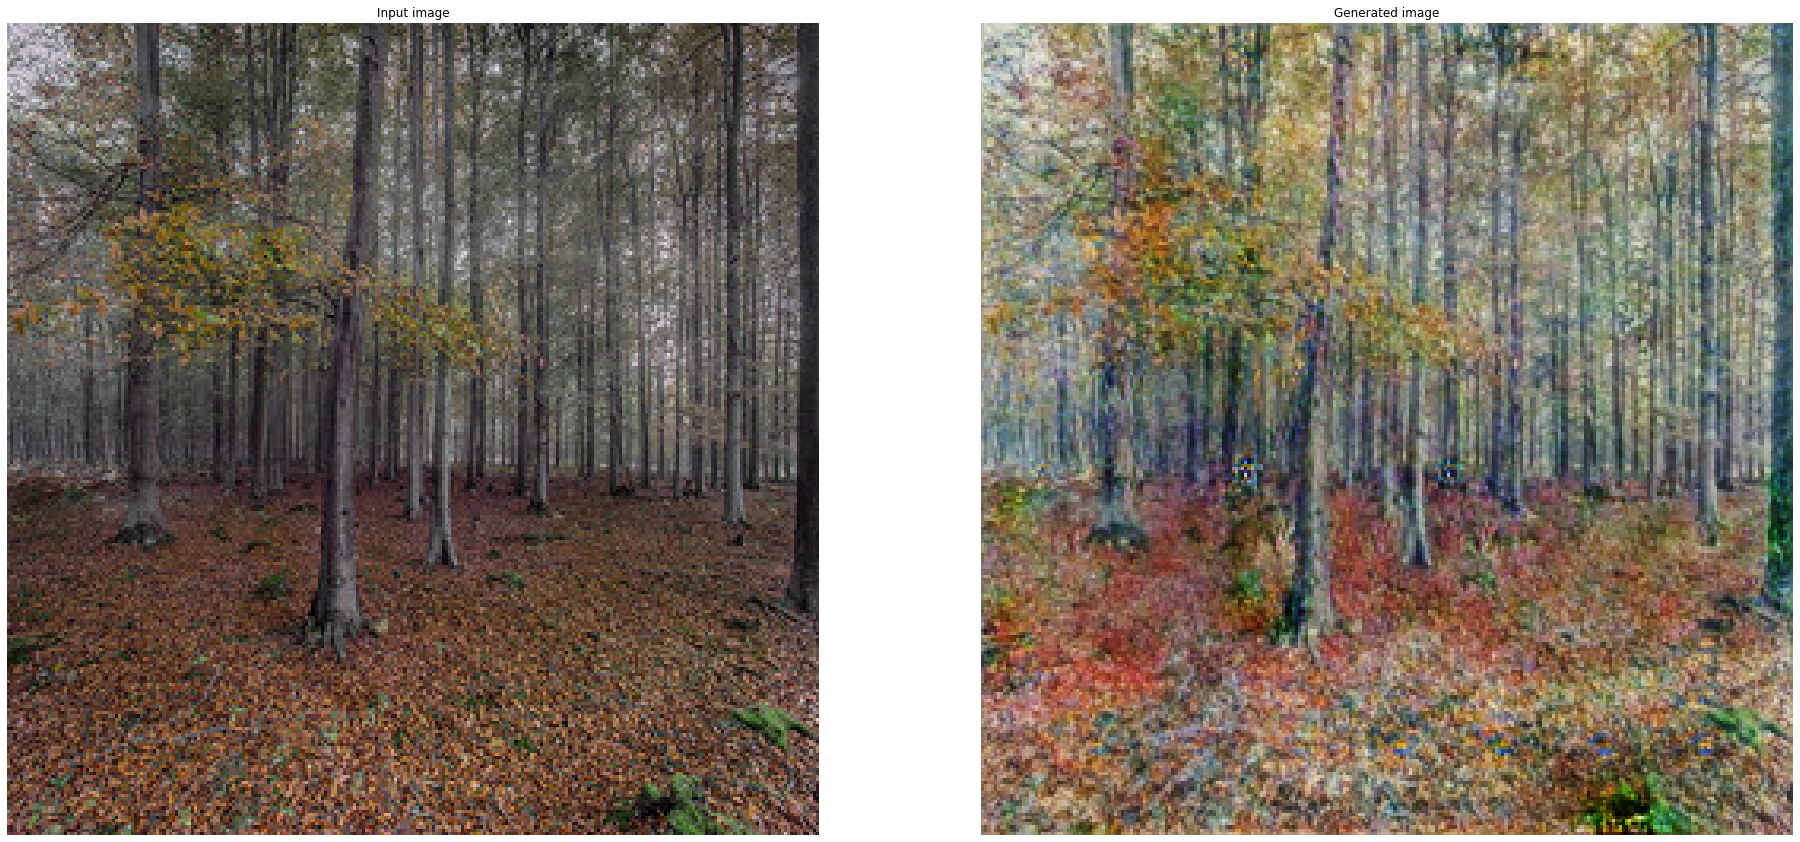

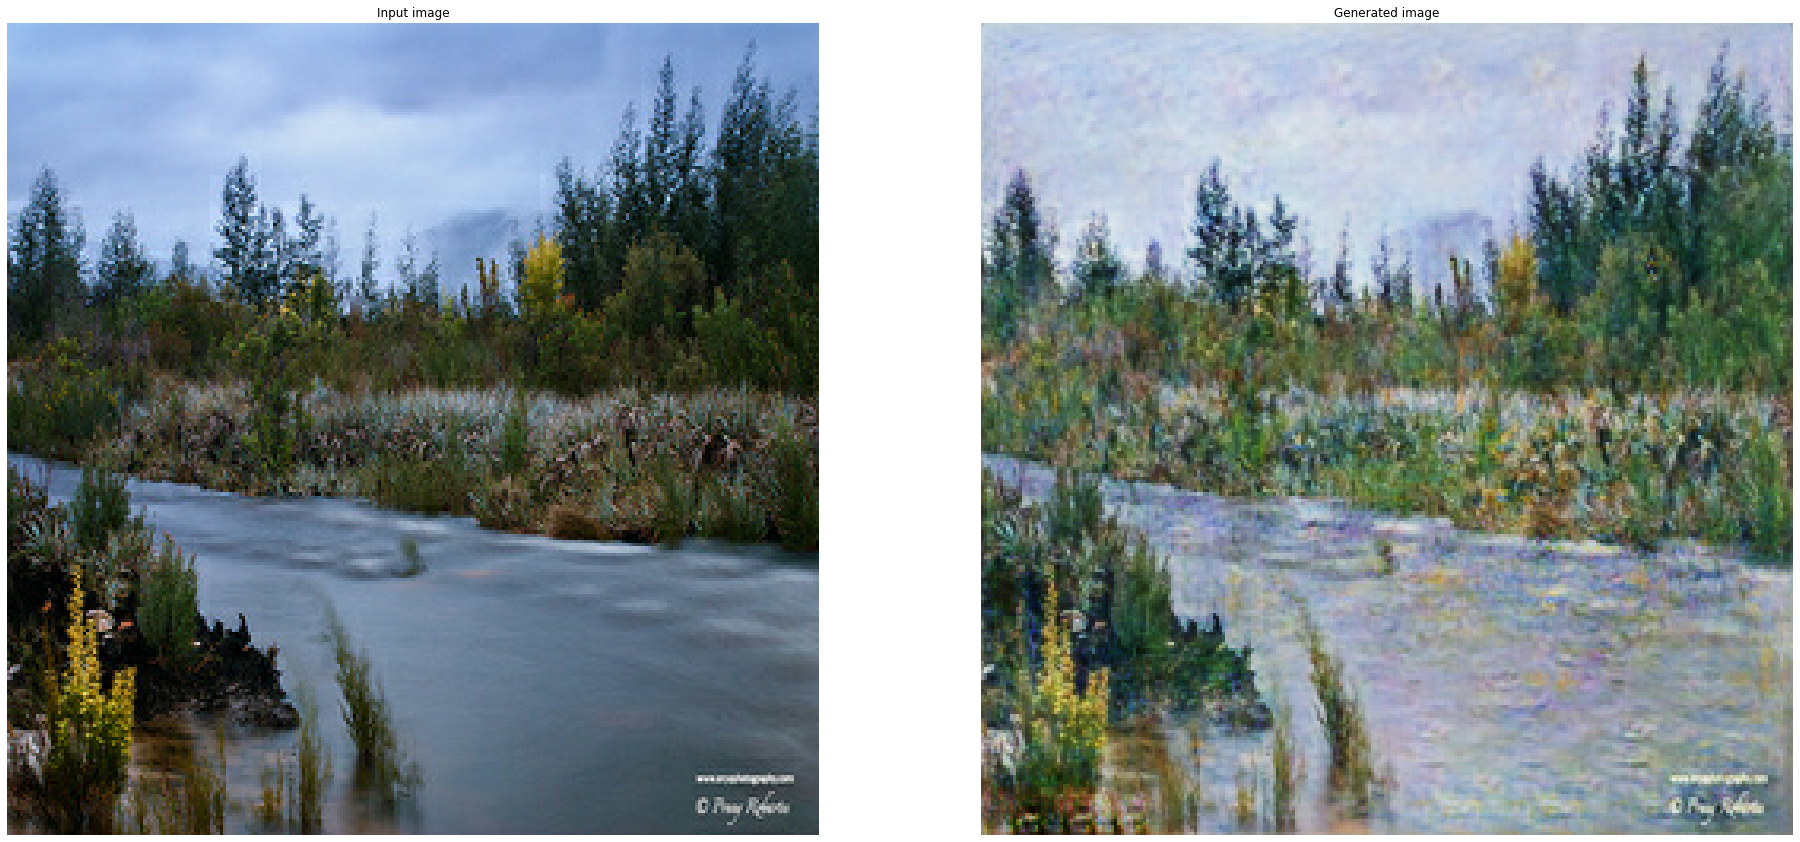

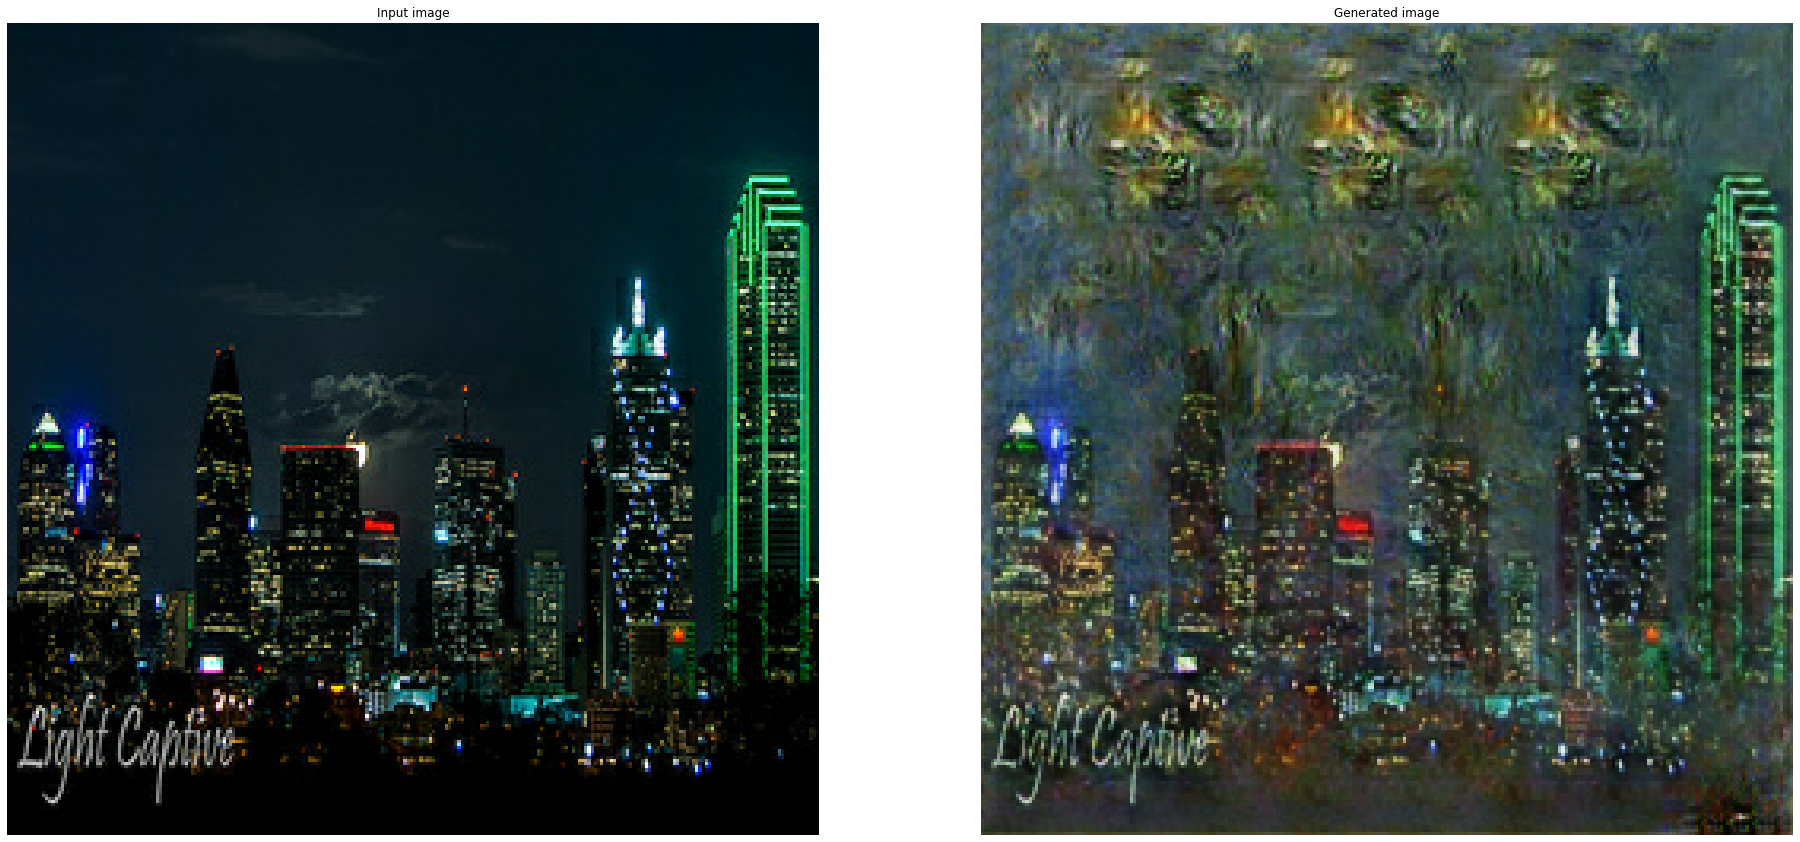

In [26]:
ds_iter = iter(photo_ds)
for n_sample in range(8):
        example_sample = next(ds_iter)
        generated_sample = monet_generator(example_sample)
        
        f = plt.figure(figsize=(32, 32))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()